# fit_baseline_CNN

Fitting arbitrary convolutional neural network (with small-ish number of epochs) to evaluate baseline performance.

--- 
- To evaluate if there are any significant differences between selecting a CNN or a FCN (see fit_baseline_FCN) for the task.
- Playing around with number of layers to check for over-fitting / under-fitting
- Once (relatively) sensible network has been chosen, this will be optimised using keras.tuner in fit_optimised_model

In [1]:
import keras 
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import model_constructors
import evaluate_model

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

### Loading in pre-processed data
- Using binary classifications [i.e. use 0 (don't use) or 1 (use)] due to intrinsic mixing between messy and clean classifications.
- Reshaping X data (i.e adding channel) for CNN input.

In [2]:
# see ../pre-processing/clean_dataset/ for more info
filepath = '/Users/chrisduckworth/projects/ML_portfolio/kin_mis_classification/CNN/pre-processing/clean_dataset_files/'

X_train = np.load(filepath + 'X_train.npy')
X_test = np.load(filepath + 'X_test.npy')
X_val = np.load(filepath + 'X_val.npy')

# adding dimension for CNN input
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
X_val = X_val[..., np.newaxis]

y_train = np.load(filepath + 'y_train_binary.npy')
y_test = np.load(filepath + 'y_test_binary.npy')
y_val = np.load(filepath + 'y_val_binary.npy')

### Plotting class counts
- Computing weights since there is a significant imbalance between the number of 0 and 1s.

/opt/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=[0 1 0 ... 1 1 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


{0: 2.055411535968892, 1: 0.6607291666666667}

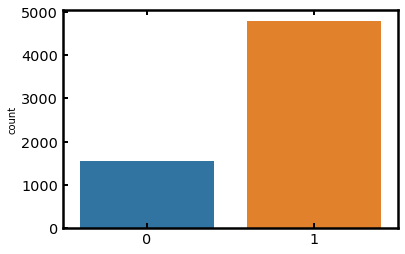

In [3]:
sns.countplot(y_train)

# computing class weights from sklearn and converting to dict (needed for keras input)
weight = class_weight.compute_class_weight('balanced', 
                                           np.unique(y_train),
                                           y_train)

weight = {i : weight[i] for i in np.arange(weight.shape[0])}
weight

### Using data generator objects to automatically augment training images to increase sample size.

In [4]:
train_gen = ImageDataGenerator(rotation_range = 180,  # randomly rotate images in the range (degrees, 0 to 180)
                               horizontal_flip = True, 
                               vertical_flip = True)  # randomly flip images

train_gen.fit(X_train)

### Loading baseline CNN and returning summary.

In [5]:
model = model_constructors.build_fixed_sequential_CNN((32, 32, 1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1048704   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

### Fitting CNN for 50 epochs
- Should identify if the model overfits (and at what point does this happen)

In [11]:
model.fit(train_gen.flow(X_train, y_train, batch_size=32),
          validation_data=(X_val, y_val), 
          class_weight=weight, epochs=50)

Epoch 1/50
199/199 [==============================] - 4s 21ms/step - loss: 0.3770 - accuracy: 0.8381 - val_loss: 0.4566 - val_accuracy: 0.8028
Epoch 2/50
199/199 [==============================] - 4s 22ms/step - loss: 0.3807 - accuracy: 0.8461 - val_loss: 0.4625 - val_accuracy: 0.8005
Epoch 3/50
199/199 [==============================] - 4s 22ms/step - loss: 0.3712 - accuracy: 0.8434 - val_loss: 0.3852 - val_accuracy: 0.8307
Epoch 4/50
199/199 [==============================] - 4s 22ms/step - loss: 0.3998 - accuracy: 0.8365 - val_loss: 0.4035 - val_accuracy: 0.8255
Epoch 5/50
199/199 [==============================] - 4s 22ms/step - loss: 0.3739 - accuracy: 0.8394 - val_loss: 0.4452 - val_accuracy: 0.8175
Epoch 6/50
199/199 [==============================] - 4s 22ms/step - loss: 0.3831 - accuracy: 0.8496 - val_loss: 0.4295 - val_accuracy: 0.8156
Epoch 7/50
199/199 [==============================] - 4s 22ms/step - loss: 0.3761 - accuracy: 0.8482 - val_loss: 0.4148 - val_accuracy: 0.8355

(0.7, 0.9)

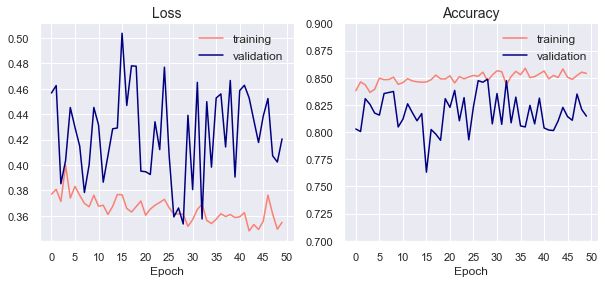

In [12]:
ax = evaluate_model.plot_loss_acc(model.history)
ax[1].set_ylim([0.7, 0.9])

In [13]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
y_predict = model.predict(X_test)
y_predict_binary = (y_predict > 0.5).astype("int32")

67/67 [==============================] - 0s 5ms/step - loss: 0.4196 - accuracy: 0.8180


### Sanity check of predicted classification histogram
- This is basically to check if it has assigned everything to a single class.. 

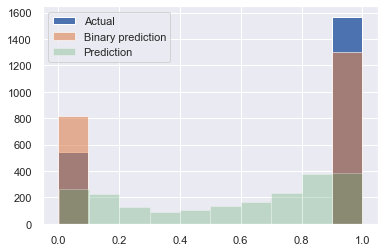

In [14]:
### Sanity check of predicted classification histogram
fig, ax = plt.subplots()
ax.hist(y_test, label='Actual')
ax.hist(y_predict_binary, alpha = 0.6, label='Binary prediction')
ax.hist(y_predict, alpha = 0.3, label='Prediction')
ax.legend()
plt.show()

### Plotting confusion matrix

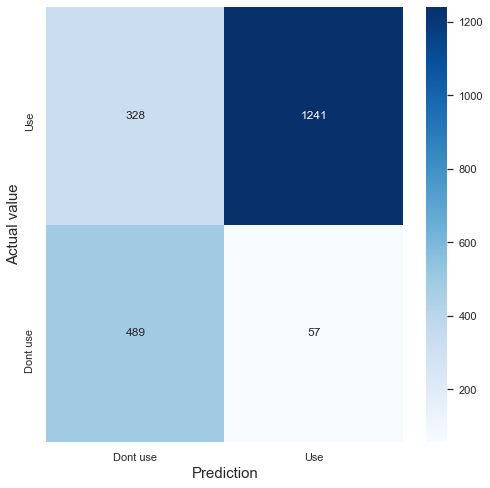

In [15]:
y_predict = model.predict(X_test)
# converting to definite classes.
y_predict_classes = (y_predict > 0.5).astype("int32")

evaluate_model.plot_confusion_matrix(y_test, y_predict_classes, labels=['Dont use', 'Use'])

### To do:
- Unpack into functions.
- Find optimal architecture using keras.tuner and number of layers.
- Introduce different functional forms for learning rate (currently using adam which may already adapt).
- Create learning rate plots and compare CNN vs FCN (for example).
- Find package to visualise selected architecture.